# Описание проекта
В проекте нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году.   
# Описание данных
В колонках датасета содержатся следующие данные:  
longitude — широта;  
latitude — долгота;  
housing_median_age — медианный возраст жителей жилого массива;  
total_rooms — общее количество комнат в домах жилого массива;  
total_bedrooms — общее количество спален в домах жилого массива;  
population — количество человек, которые проживают в жилом массиве;  
households — количество домовладений в жилом массиве;  
median_income — медианный доход жителей жилого массива;  
median_house_value — медианная стоимость дома в жилом массиве;  
ocean_proximity — близость к океану.  

# Задачи проекта
На основе данных нужно предсказать медианную стоимость дома в жилом массиве — median_house_value. Для оценки качества модели использовать метрики RMSE, MAE и R2.

# Инструменты 
Pyhton  
Pandas  
Spark

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Предобратока-данных" data-toc-modified-id="Предобратока-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобратока данных</a></span></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></div>

# Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.


In [1]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import six
import pyspark.sql.functions as F
import os

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import pandas as pd 
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022

from IPython.core.display import display, HTML

conf = {
    'spark.dynamicAllocation.enabled': 'true',
	'spark.shuffle.service.enabled': 'true',
    'spark.dynamicAllocation.maxExecutors': 2,
    'spark.executor.memory': '32g',
    'spark.executor.cores': '4',
    'spark.driver.memory': '4g',
    'spark.sql.debug.maxToStringFields': 500,
    
}

builder = (
    SparkSession\
    .builder\
    .master("local")\
    .appName("CaliforniaHouseing ML 2 Attempt superTrubo")
)

for k, v in conf.items():
    builder.config(k, v)

spark = builder.getOrCreate()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16556\688085115.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import mean, col

In [6]:
#Это путь для загурзки в среде Практикума
file_location1 = "datasets/housing.csv"
file_location2 = "/datasets/housing.csv"

if os.path.exists(file_location1):
    file_location = file_location1
elif os.path.exists(file_location2):
    file_location = file_location2
else:
    print('Something is wrong')

In [7]:
file_type = "csv"

# The applied options are for CSV files. For other file types, these will be ignored.
df =spark.read.csv(file_location,header=True,inferSchema=True)
df.toPandas().head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## Подготовка данных

In [8]:
display(HTML(df.printSchema()))

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



<IPython.core.display.HTML object>

In [9]:
df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [10]:
#Выведите типы данных колонок датасета. Используйте методы pySpark.
print(pd.DataFrame(df.dtypes, columns=['column', 'type']))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


## Предобратока данных

In [11]:
#Исследуем данные на наличие пропусков
a=df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()#.show()
table_width = '90%'
df_html = a.style.set_table_attributes(f'style="width: {table_width};"').render()

# Выводим таблицу в HTML
HTML(df_html)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16556\2834648674.py:4: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  df_html = a.style.set_table_attributes(f'style="width: {table_width};"').render()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,0,0,0,207,0,0,0,0,0


Обнаружили что пропуски есть только в количестве спален. Но их всего 207, так что если мы не очень корректно их заполним, будет не так страшно.

In [12]:
#Заменим пропуски в спальнях на среднее количество спален
df = df.na.fill(df.select(mean(col("total_bedrooms"))).first()[0], subset=["total_bedrooms"])
df = df.withColumnRenamed('median_house_value', 'label')

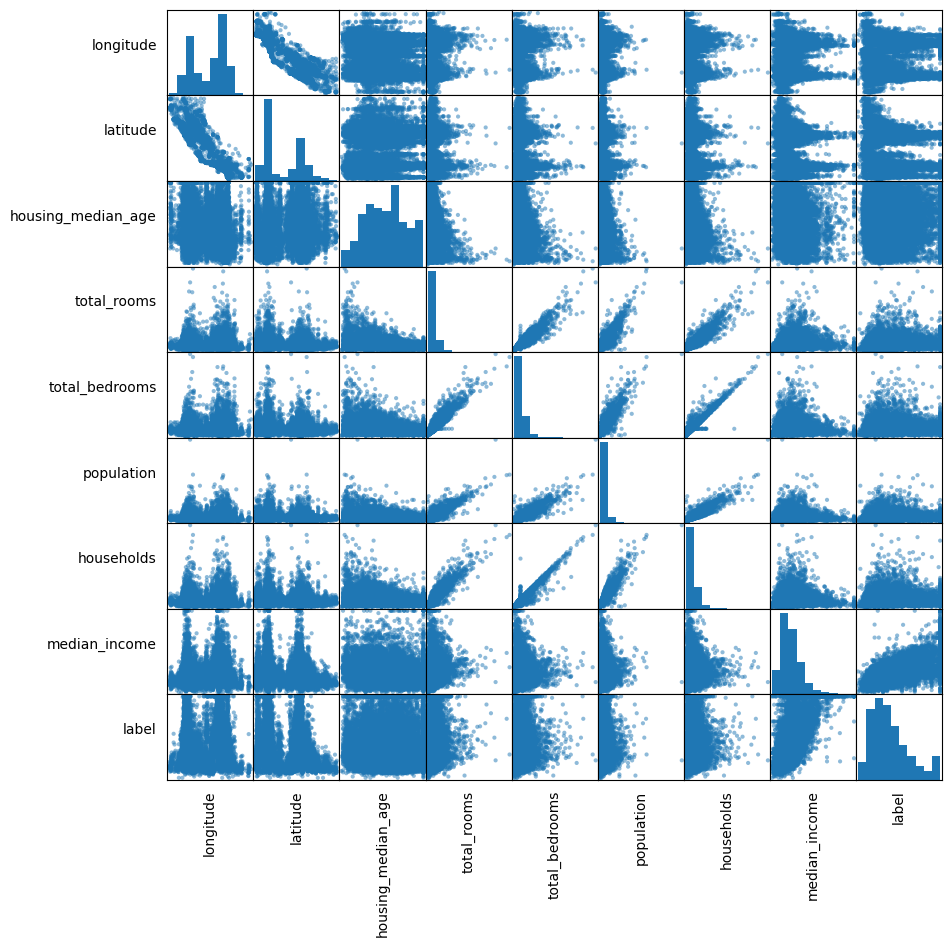

In [13]:
#Проверим, как обстоит дело с корреляцией
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                    'households', 'median_income','label']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Это трудно увидеть. Давайте найдем корреляцию между независимыми переменными и целевой переменной.

In [14]:
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to median_house_value for ", i, df.stat.corr('label',i))

Correlation to median_house_value for  longitude -0.045966615117981745
Correlation to median_house_value for  latitude -0.14416027687465752
Correlation to median_house_value for  housing_median_age 0.10562341249321067
Correlation to median_house_value for  total_rooms 0.13415311380656275
Correlation to median_house_value for  total_bedrooms 0.04945354544322849
Correlation to median_house_value for  population -0.024649678888894876
Correlation to median_house_value for  households 0.06584265057005637
Correlation to median_house_value for  median_income 0.6880752079585578
Correlation to median_house_value for  label 1.0


**Вывод**
- Есть достаточно значительная корреляция стоимости дома и дохода его хозяев, что понятно, но при этом 0,688 это ещё не то значение чтобы выкидывать из модели такой важный показатель!

# Теперь попробуем сделать один трубопровод, в котором будет сразу и подготовка данных и построение модели.

In [36]:
str_cols=['ocean_proximity']
#У нас одна категориальная колонка, превратим её в индексы
indexer=StringIndexer(inputCols=str_cols,outputCols=[c+'_idx' for c in str_cols]).setHandleInvalid("keep")
#Теперь сделаем для всех индексов свои колонки техникой One hot encoding.
encoder = OneHotEncoder(inputCol="ocean_proximity_idx",
                        outputCol="ocean_proximity_ohe")
#Загоним теперь все получившиеся колонки в один вектор
categorical_assembler = \
        VectorAssembler(inputCols=["ocean_proximity_ohe"],
                                        outputCol="categorical_features").setHandleInvalid("keep")
#Преобразуем в вектор числовые переменные
numerical_cols=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
                'population','households','median_income']
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                                                            outputCol="numerical_features").setHandleInvalid("keep")
#Стандартизуем получившийся вектор, чтобы ничего не выпирало
standardScaler = StandardScaler(inputCol='numerical_features',
                                                                outputCol="numerical_features_scaled",withMean=True)
all_features = ['categorical_features','numerical_features_scaled']
#А теперь соберём в единый вектор все наши перменные
final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features").setHandleInvalid("keep") 
#Построим две модели. В первой используем все данные, во второй - только числовые.
regressor1=LinearRegression(featuresCol='features', labelCol='label')
regressor2=LinearRegression(featuresCol='numerical_features_scaled', labelCol='label')

In [37]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|341300.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1627.0|         280.0|     565.0|     259.0|       3.8462|34

In [38]:
#Теперь заказтаем всё это в один трубопровод:
pipeline = Pipeline(stages=[indexer, encoder, categorical_assembler,numerical_assembler,standardScaler,final_assembler,regressor1])
pipeline_dig=Pipeline(stages=[numerical_assembler,standardScaler,regressor2])

In [39]:
#Чтобы потом можно было проверить качество модели разделим датасет на тренировочный и тестовый
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count())


16418 4222


In [40]:
model1 = pipeline.fit(train_data)
model2 = pipeline_dig.fit(train_data)

## Анализ результатов

In [46]:
#Сравним результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2.

rezz=pd.DataFrame(columns=['Model','RMSE','R2','MAE'])
i=0
ml=['Регрессия: Все данные','Регрессия: Числовые данные']
for model in [model1,model2]:
    pred_results=model.transform(test_data)
    #results = pred_results.select(['prediction', 'median_house_value'])
    evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(pred_results)  # Расчет RMSE
    evaluator.setMetricName("r2")
    r2 = evaluator.evaluate(pred_results)  # Расчет R2
    evaluator.setMetricName("mae")
    mae = evaluator.evaluate(pred_results)  # Расчет MAE
    rezz.loc[len(rezz.index)] = [ml[i],rmse,r2,mae]
    i=i+1

In [47]:
rezz

,Model,RMSE,R2,MAE
0,Регрессия: Все данные,68480.413401,0.653622,49849.341044
1,Регрессия: Числовые данные,69207.629961,0.646226,50848.475110


ВЫВОД:
- Получились две модели, предсказывающие стоимость дома, исходя из имеющихся характеристик.
- Модели не сильно отличаются по демонстрируемым метрикам.
- Модель используюящая все признаки несколько лучше учитывает зависимость целевой переменной от имеющихся данных (всего на 1%), но при этом даём и несколько меньшие значения как ошибок, так и квадратов ошибок, так что можно сказать, что от чёта близости к океану какой-то толк есть.
- Модель рассчитанная исходя их числовых признаком уступает в среднем на 2% по размеру ошибок, что в не сказать чтобы имело большое значение, на фоне того, что R2 у нас весьма далеко от 100%, но и дома в Калифорнии это штучный товар. Сравим с производительностью "прямолинейного алгоритма".

In [48]:
raw=pd.read_csv('datasets/housing.csv')
dummy_clf = DummyClassifier(strategy="most_frequent")
f_cols=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households',
        'median_income']

In [49]:
features_train, features_valid, target_train, target_valid = train_test_split(raw[f_cols], raw['median_house_value'], test_size=0.2, random_state=12345)

In [50]:
str=["most_frequent", "prior", "stratified", "uniform"]
for i in str:
    dummy_clf = DummyClassifier(strategy=i)
    dummy_clf.fit(raw[f_cols], raw['median_house_value'])
    predictions=dummy_clf.predict(features_valid)
    mean_absolute_error_= mean_absolute_error(target_valid, predictions)
    r2_score_= r2_score(target_valid, predictions)
    mean_squared_error_= mean_squared_error(target_valid, predictions)
    rezz.loc[len(rezz.index)] = [i,mean_squared_error_,r2_score_,mean_absolute_error_]
rezz

,Model,RMSE,R2,MAE
0,Регрессия: Все данные,6.848041e+04,0.653622,49849.341044
1,Регрессия: Числовые данные,6.920763e+04,0.646226,50848.475110
2,most_frequent,9.840337e+10,-6.395776,291715.657219
3,prior,9.840337e+10,-6.395776,291715.657219
4,stratified,2.644083e+10,-0.987234,125897.911579
5,uniform,2.922588e+10,-1.196552,138428.803052


**Вывод**

- Полученные модели всё-таки лучше чем "прямолинейные алгоритмы", так как те влияние признаком совсем не учитывает, отрицательное значете R2 говорит, что модель всё даёт "диаметрально противоположные" предсказания. Ну и средняя абсолютная ошибка просто чудовищно превосходит нашу линейную регрессию.
- Мне жаль, что я не нашёл как применить dummy-алгоритмы напрямую к saprk.DataFrame, кажется эта библиотека их не поддерживает.
- Ну и конечно я всё делал локально, так что выиграша в скорости не заметил. Хотелось бы попробовать на настоящем кластере.